In [3]:
import random

from gerrychain.tree import bipartition_tree

In [4]:
import matplotlib.pyplot as plt
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election)
from gerrychain.proposals import recom
from functools import partial
import pandas as pd
import geopandas as gpd
import csv
import os
import datetime  #For keeping track of runtime
import tqdm # for progress bar

os.getpid()

34532

In [5]:
beginrun = datetime.datetime.now()
print ("\nBegin date and time : ", beginrun.strftime("%Y-%m-%d %H:%M:%S"))


Begin date and time :  2025-05-12 18:46:31


In [6]:
outdir="./NM_recom_SOS18/"

In [7]:
total_steps_in_run=1000000
save_district_graph_mod=100000
save_district_plot_mod=100000

In [8]:
os.makedirs(outdir, exist_ok=True)
graph = Graph.from_file("NM/NM.shp")


In [9]:
elections = [
	Election("USS18", {"Democratic": "G18USSD", "Republican": "G18USSR"}),
	Election("GOV18", {"Democratic": "G18GOVD", "Republican": "G18GOVR"}),
	Election("SOS18", {"Democratic": "G18SOSD", "Republican": "G18SOSR"}),
	Election("TRE18", {"Democratic": "G18TRED", "Republican": "G18TRER"}),
	Election("ATG18", {"Democratic": "G18ATGD", "Republican": "G18ATGR"}),
	Election("AUD18", {"Democratic": "G18AUDD", "Republican": "G18AUDR"}),
	Election("LND18", {"Democratic": "G18LNDD", "Republican": "G18LNDR"}),
	]
sample_node = next(iter(graph.nodes(data=True)))
print(sample_node[1].keys())



dict_keys(['boundary_node', 'area', 'STATEFP', 'COUNTYFP', 'COUNTYNAME', 'VTDST', 'NAME', 'G20PRED', 'G20PRER', 'G20SACDIVE', 'G20SACRJOH', 'G20SACDHEN', 'G20SACRLEE', 'G20SACLCUR', 'G20SACDYOH', 'G20SACRMON', 'TOTPOP', 'HISP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP', 'G18USSD', 'G18USSR', 'G18GOVD', 'G18GOVR', 'G18SOSD', 'G18SOSR', 'G18TRED', 'G18TRER', 'G18ATGD', 'G18ATGR', 'G18AUDD', 'G18AUDR', 'G18LNDD', 'G18LNDR', 'SACD', 'geometry'])


In [10]:
my_updaters = {
	"population": updaters.Tally("TOTPOP", alias="population"),
	"HISP": updaters.Tally("HISP", alias="HISP")
	}


In [11]:
for _, data in graph.nodes(data=True):
	print(data.keys())
	break

election_updaters = {election.name: election for election in elections}
my_updaters.update(election_updaters)

dict_keys(['boundary_node', 'area', 'STATEFP', 'COUNTYFP', 'COUNTYNAME', 'VTDST', 'NAME', 'G20PRED', 'G20PRER', 'G20SACDIVE', 'G20SACRJOH', 'G20SACDHEN', 'G20SACRLEE', 'G20SACLCUR', 'G20SACDYOH', 'G20SACRMON', 'TOTPOP', 'HISP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP', 'G18USSD', 'G18USSR', 'G18GOVD', 'G18GOVR', 'G18SOSD', 'G18SOSR', 'G18TRED', 'G18TRER', 'G18ATGD', 'G18ATGR', 'G18AUDD', 'G18AUDR', 'G18LNDD', 'G18LNDR', 'SACD', 'geometry'])


In [12]:
initial_partition = GeographicPartition(graph,
                                        assignment= "SACD", #"2011_PLA_1",     # "GOV", "REMEDIAL_P", 
                                        updaters=my_updaters)

In [13]:
ideal_population = sum(initial_partition["population"].values()) / len(initial_partition)

In [14]:
proposal = partial(recom,
                   pop_col="TOTPOP",
                   pop_target=ideal_population,
                   epsilon=0.1,
                   node_repeats=3
                   )

In [15]:
compactness_bound = constraints.UpperBound(
	lambda p: len(p["cut_edges"]),
	2*len(initial_partition["cut_edges"])
	)

In [16]:
pop_constraint = constraints.within_percent_of_ideal_population(initial_partition, 0.15)

In [17]:
chain = MarkovChain(
	proposal=proposal,
	constraints=[
		pop_constraint,
		compactness_bound
		],
	accept=accept.always_accept,
	initial_state=initial_partition,
	total_steps=total_steps_in_run,
	)



In [18]:
data = pd.DataFrame(
	sorted(partition["SOS18"].percents("Democratic"))
	for partition in chain.with_progress_bar()
	)
num_dist = len(set(initial_partition.assignment.values()))


C:\Users\Paul Maresquier\Documents\School\CS 464\NMHouse\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 25/1000000 [00:00<1:09:06, 241.17it/s]C:\Users\Paul Maresquier\Documents\School\CS 464\NMHouse\.venv\Lib\site-packages\gerrychain\tree.py:704: BipartitionWarning: 
Failed to find a balanced cut after 1000 attempts.
If possible, consider enabling pair reselection within your
MarkovChain proposal method to allow the algorithm to select
a different pair of districts for recombination.
  warnings.warn(
100%|██████████| 1000000/1000000 [53:04<00:00, 314.02it/s] 


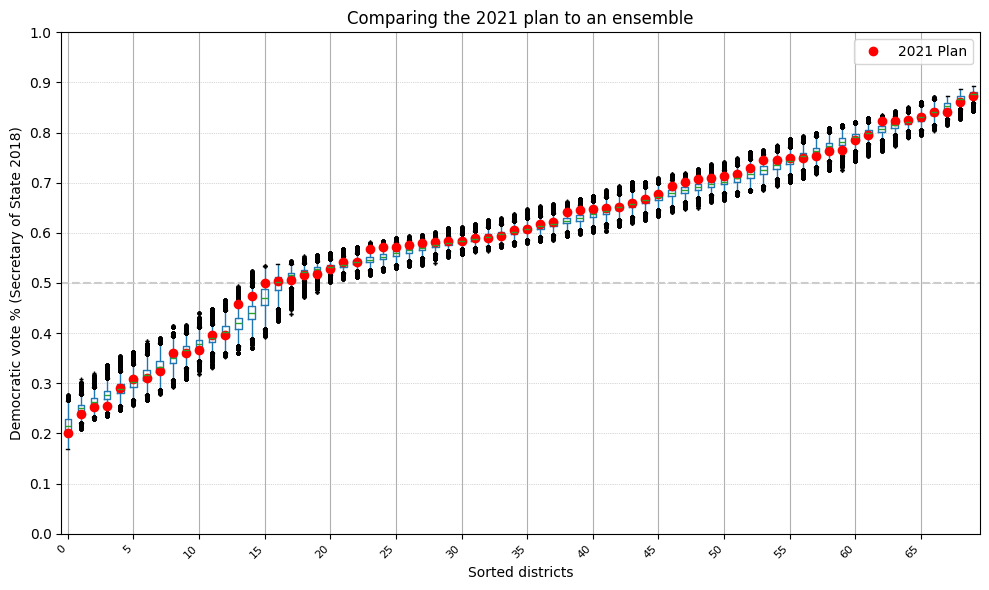

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))  # Slightly wider for clarity

# Draw 50% horizontal line
ax.axhline(0.5, color="#cccccc", linestyle='--')

# Draw boxplot of ensemble
flierprops = dict(markerfacecolor="k", marker='+', markeredgewidth=1, markersize=3)
data.boxplot(ax=ax, positions=range(len(data.columns)), showfliers=True, flierprops=flierprops)

# Draw red dots for 2021 plan (first row)
ax.plot(data.iloc[0], "ro", label="2021 Plan")

# Beautify X-axis: Show fewer ticks and rotate labels
ax.set_xticks(range(0, len(data.columns), 5))  # Show every 5th district
ax.set_xticklabels(range(0, len(data.columns), 5), rotation=45, ha="right", fontsize=8)

# Titles and labels
ax.set_title("Comparing the 2021 plan to an ensemble")
ax.set_ylabel("Democratic vote % (Secretary of State 2018)")
ax.set_xlabel("Sorted districts")
ax.set_ylim(0.25, 1)
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

ax.grid(True, axis='y', linestyle=':', linewidth=0.5)
ax.legend()

plt.tight_layout()
plt.show()

In [20]:
df=gpd.read_file("NM/NM.shp")

In [21]:
index_output_file = outdir + "_index.csv"

In [22]:
dem_won = []
egs = []
edges = []

In [23]:
def eg(part):
	election_results = part['GOV18']
	dem_counts = election_results.votes("Democratic")
	rep_counts = election_results.votes("Republican")

	wasted_votes_dem = 0
	wasted_votes_rep = 0
	dem_won.append(0)

	for i in range(
			len(dem_counts)
			):  # <- not super familar with python so i used chatGPT with help on how to loop through a tuple
		votes_dem = dem_counts[i]
		votes_rep = rep_counts[i]
		#calculating the total number of votes in the district and the minimum number of votes needed to win the district
		total_votes = votes_dem + votes_rep
		min_winning_votes = (total_votes // 2) + 1
		# if the democratic candidate wins the district then the wasted votes for the republican candidate is the number of votes the republican candidate received
		if votes_dem > votes_rep:
			wasted_votes_dem += votes_dem - min_winning_votes
			wasted_votes_rep += votes_rep
			dem_won[-1] += 1
		else:
			wasted_votes_dem += votes_dem
			wasted_votes_rep += votes_rep - min_winning_votes
	#calculating the efficiency gap by subtracting the wasted votes of the democratic candidate from the wasted votes of the republican candidate and dividing by the total number of votes
	total_votes_all = sum(dem_counts) + sum(rep_counts)
	efficiency_gap = (wasted_votes_rep - wasted_votes_dem) / total_votes_all
	egs.append(efficiency_gap)

	return efficiency_gap

def cut_edges_count(part):
	graph = part.graph
	assignment = part.assignment
	count = 0
	for node in graph.nodes:
		district = assignment[node]
		for neighbor in graph.neighbors(node):
			if assignment[neighbor] != district:
				count += 1

	edges.append(count // 2)

	return count // 2  # Each cut edge is counted twice (once from each node), so divide by 2

In [25]:
with open(index_output_file, mode='w') as index_file:
	index_writer = csv.writer(index_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

	# Run through chain, building outputs
	for t, part in enumerate(tqdm.tqdm(chain)):
		cut_edges_count(part)
		eg(part)
		if t % save_district_graph_mod == 0 or t == len(chain)-1:
		    tmp_str = str(t)
		    file_prefix = tmp_str.rjust(8, '0')

		    # Add file names to index file
		    edges_output_file = outdir + file_prefix + "_edges.csv"
		    districts_output_file = outdir + file_prefix + "_districts.csv"
		    index_writer.writerow(["./" + file_prefix + "_districts.csv", "./" + file_prefix + "_edges.csv"])

		    # Build the district graph and write edges to file
		    s = set()
		    for e in part["cut_edges"]:
		        s.add((part.assignment[e[0]], part.assignment[e[1]]))

		    with open(edges_output_file, mode='w') as edges_file:
		        edges_writer = csv.writer(edges_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
		        for e1 in s:
		            edges_writer.writerow([e1[0], e1[1]])

		    # Build the district file that contains election results
		    D_votes = part["SOS18"].votes("Democratic")
		    R_votes = part["SOS18"].votes("Republican")

		    with open(districts_output_file, mode='w') as districts_file:
		        districts_writer = csv.writer(districts_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
		        for i in range(len(D_votes)):
		            districts_writer.writerow([i + 1, int(D_votes[i]), int(R_votes[i]), 0])

		    # Save map plot
		    if t % save_district_plot_mod == 0 or t == len(chain)-1:
		        df.plot(pd.Series([part.assignment[i] for i in df.index]), cmap="tab20", figsize=(16,8))
		        plot_output_file = outdir + file_prefix + "_plot.png"
		        plt.savefig(plot_output_file)
		        plt.close()

		    # Create and save Hispanic % histogram
		    num_dist = len(set(part.assignment.values()))
		    hisp_percents = []

		    for district_id in part["population"]:
		        total = part["population"][district_id]
		        hisp = part["HISP"][district_id]
		        if total > 0:
		            hisp_percents.append(hisp / total)

		    # Calculate mean Hispanic percentage across all districts
		    mean_hispanic_pct = sum(hisp_percents) / len(hisp_percents)

		    plt.figure(figsize=(8, 5))
		    plt.hist(hisp_percents, bins=10, edgecolor='black')
		    plt.axvline(mean_hispanic_pct, color='red', label=f'Value for Plan: {mean_hispanic_pct:.2f}')
		    plt.title(f"Hispanic Population % per District (Step {t})")
		    plt.xlabel("Hispanic Population Percentage")
		    plt.ylabel("Number of Districts")
		    plt.legend()
		    hist_output_file = outdir + file_prefix + "_hispanic_hist.png"
		    plt.savefig(hist_output_file)
		    plt.close()


  3%|▎         | 28390/1000000 [01:58<1:05:54, 245.69it/s]C:\Users\Paul Maresquier\Documents\School\CS 464\NMHouse\.venv\Lib\site-packages\gerrychain\tree.py:704: BipartitionWarning: 
Failed to find a balanced cut after 1000 attempts.
If possible, consider enabling pair reselection within your
MarkovChain proposal method to allow the algorithm to select
a different pair of districts for recombination.
  warnings.warn(
100%|██████████| 1000000/1000000 [1:09:50<00:00, 238.64it/s]


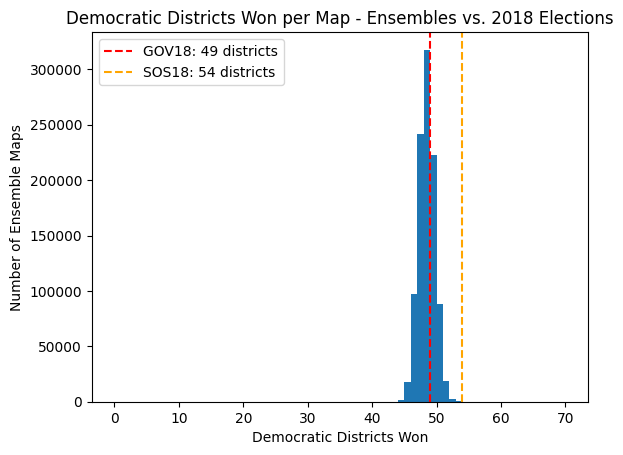

In [26]:
plt.hist(dem_won, 70, (0, 70))
plt.title("Democratic Districts Won per Map - Ensembles vs. 2018 Elections")
plt.axvline(49, color="red", linestyle='--', label="GOV18: 49 districts")
plt.axvline(54, color="orange", linestyle='--', label="SOS18: 54 districts")
plt.xlabel("Democratic Districts Won")
plt.ylabel("Number of Ensemble Maps")
plt.legend()
plt.show()

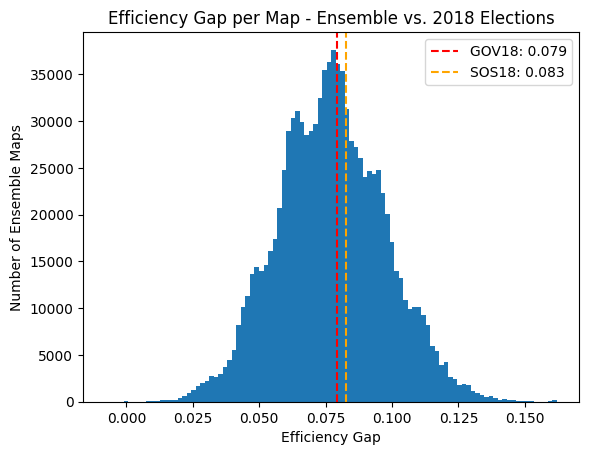

In [27]:
plt.hist(egs, 100)
plt.title("Efficiency Gap per Map - Ensemble vs. 2018 Elections")
plt.axvline(0.07919633460117526, color="red", linestyle='--', label="GOV18: 0.079")
plt.axvline(0.08283925415879585, color="orange", linestyle='--', label="SOS18: 0.083")
plt.xlabel("Efficiency Gap")
plt.ylabel("Number of Ensemble Maps")
plt.legend()
plt.show()

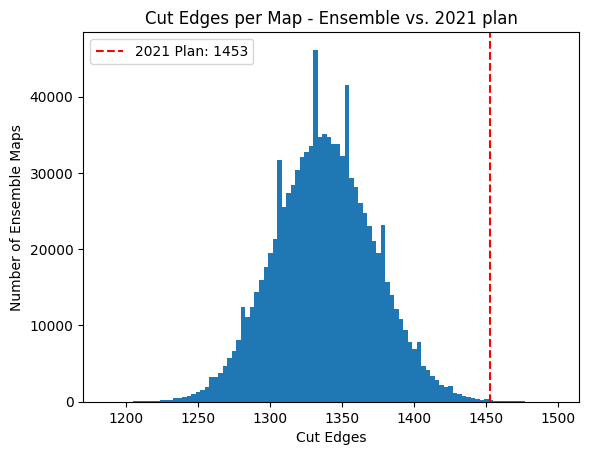

In [28]:
plt.show()
plt.hist(edges, 100)
plt.title("Cut Edges per Map - Ensemble vs. 2021 plan")
plt.axvline(1453, color="red", linestyle='--', label="2021 Plan: 1453")
plt.xlabel("Cut Edges")
plt.ylabel("Number of Ensemble Maps")
plt.legend()
plt.show()

And if you want to find the total time:

In [55]:
endrun = datetime.datetime.now()
print ("\nEnd date and time : ", endrun.strftime("%Y-%m-%d %H:%M:%S"))


diff=endrun-beginrun
print("\nTotal time: ", str(diff))


End date and time :  2025-05-10 23:14:34

Total time:  1:40:31.377615
